In [1]:
from bi_function import BI_PROJECT_ID,BI_CLIENT,read_from_gbq

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

In [2]:
# 1. Data Query

# To maintain consistency in observations, this notebook uses a static table by filtering the data period.
df = read_from_gbq(BI_CLIENT,f'''SELECT date,cmrk_data_ts as data_ts,cmrk_currency as currency,coin_id,coin_symbol,coin_name,
                                        mkch_price,mkch_market_cap,mkch_volume,
                                        ohlc_open,ohlc_high,ohlc_low,ohlc_close,
                                        cmrk_image,cmrk_current_price,cmrk_market_cap,cmrk_market_cap_rank,
                                        cmrk_fully_diluted_valuation,cmrk_total_volume,cmrk_high_24h,cmrk_low_24h,
                                        cmrk_price_change_24h,cmrk_price_change_percentage_24h,cmrk_market_cap_change_24h,
                                        cmrk_market_cap_change_percentage_24h,cmrk_circulating_supply,cmrk_total_supply,
                                        cmrk_max_supply,cmrk_ath,cmrk_ath_change_percentage,cmrk_ath_date,cmrk_atl,
                                        cmrk_atl_change_percentage,cmrk_atl_date,cmrk_roi,cmrk_last_updated,
                                        cmrk_price_change_percentage_1h_in_currency,cmrk_price_change_percentage_24h_in_currency,
                                        cmrk_price_change_percentage_7d_in_currency,cmrk_price_change_percentage_14d_in_currency,
                                        cmrk_price_change_percentage_30d_in_currency,cmrk_price_change_percentage_200d_in_currency,
                                        cmrk_price_change_percentage_1y_in_currency,
                                        trdg_img_thumb,trdg_img_small,trdg_img_large,trdg_score,trdg_sparkline,
                                        trending_flag
                                 FROM `{BI_PROJECT_ID}.cryptocurrency.cgc_a_market_historical_data`
                                 WHERE date BETWEEN '2024-01-01' AND '2024-11-30' ''')

In [3]:
# 2. Handle Missing Value

missing_values = df.isnull().mean() * 100 # Calculate the percentage of missing values for each column
missing_values = missing_values[missing_values > 0].sort_values(ascending=False) # Filter only columns with missing values
print(missing_values)

for s in ['trdg_img_thumb','trdg_img_small','trdg_img_large','trdg_sparkline']:
    df[s] = df[s].fillna('-')

# This column below represents the trending score, and 9999 is used as a default value to indicate "not trending."
df['trdg_score'] = df['trdg_score'].fillna(9999)

# Drop the `cmrk_roi` column due to high percentage of missing values (>85%) and not essential for analysis at this moment
df = df.drop(columns=['cmrk_roi'],errors='ignore')

# Leave critical columns with missing values (e.g., `ohlc_*`, `cmrk_max_supply`, etc.) as it is.
# These values are essential for analysis, so no imputation (mean, median, or forward filling) is applied.

trdg_score                                       89.828799
trdg_sparkline                                   89.828799
trdg_img_small                                   89.828799
trdg_img_large                                   89.828799
trdg_img_thumb                                   89.828799
cmrk_roi                                         84.096371
ohlc_open                                        74.936949
ohlc_close                                       74.936949
ohlc_low                                         74.936949
ohlc_high                                        74.936949
cmrk_max_supply                                  39.257633
cmrk_price_change_percentage_1y_in_currency       8.566003
cmrk_price_change_percentage_200d_in_currency     1.305522
cmrk_price_change_percentage_30d_in_currency      0.005934
dtype: float64


In [4]:
# 3. Split Time Series and Snapshot Data

historical_columns = ['date', 'currency', 'coin_id', 'coin_symbol', 'coin_name'] + \
                     [col for col in df.columns if col.startswith('mkch_') or col.startswith('ohlc_')]
df_historical = df[historical_columns]

# Create the snapshot dataframe with columns tied to 'data_ts' and remove duplicates
snapshot_columns = ['data_ts', 'currency', 'coin_id', 'coin_symbol', 'coin_name'] + \
                   [col for col in df.columns if col.startswith('cmrk_')]
df_snapshot = df[snapshot_columns].drop_duplicates().reset_index(drop=True)

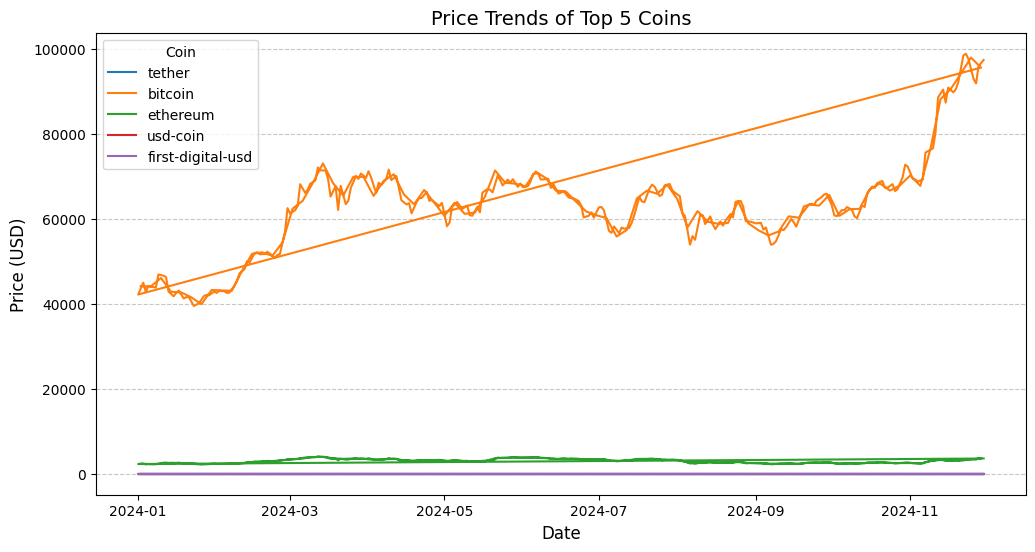

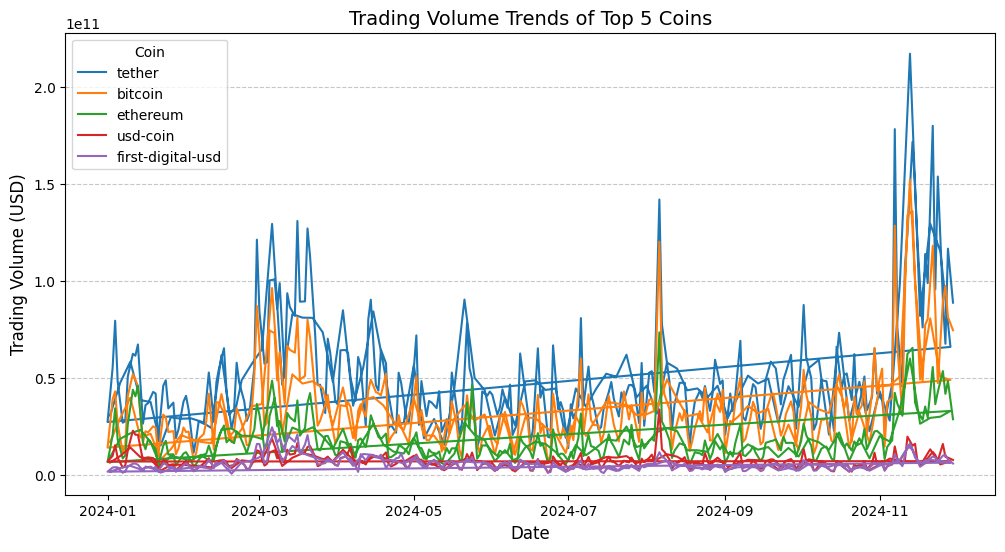

In [5]:
# 4. Exploratory Data Analysis (EDA)

# Step 4.1: Identify top 5 coins by average trading volume (`mkch_volume`)
top_coins_by_volume = (
    df_historical.groupby('coin_id')['mkch_volume']
    .mean()
    .sort_values(ascending=False)
    .head(5)
    .index.tolist()
)

# Filter the historical data for top 5 coins
df_top_coins = df_historical[df_historical['coin_id'].isin(top_coins_by_volume)]

# Step 4.2: Plot trends for `mkch_price` and `mkch_volume` over time

# Plot Price Trends
plt.figure(figsize=(12, 6))
for coin in top_coins_by_volume:
    coin_data = df_top_coins[df_top_coins['coin_id'] == coin]
    plt.plot(coin_data['date'], coin_data['mkch_price'], label=coin)

plt.title('Price Trends of Top 5 Coins', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(title='Coin', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot Volume Trends
plt.figure(figsize=(12, 6))
for coin in top_coins_by_volume:
    coin_data = df_top_coins[df_top_coins['coin_id'] == coin]
    plt.plot(coin_data['date'], coin_data['mkch_volume'], label=coin)

plt.title('Trading Volume Trends of Top 5 Coins', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Trading Volume (USD)', fontsize=12)
plt.legend(title='Coin', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### **Price Trends of Top 5 Coins**

1. **Bitcoin:**
   - **Highest Price:** Bitcoin continues to dominate, reaching a peak price close to **$100,000 in December 2024**.
   - **Trend:** Bitcoin maintains a **consistent upward trend** throughout the year, with notable dips during **mid-year (May–July 2024)** but strong recovery in the latter half.
   - **Observation:** The sustained growth highlights robust market confidence, reflecting increased demand and possible external drivers like institutional adoption or market sentiment.

2. **Ethereum:**
   - **Gradual Increase:** Ethereum displays a steady price increase, aligning with Bitcoin’s uptrend but within a narrower price range.
   - **Price Peak:** Ethereum’s price peaks in **November 2024**, coinciding with Bitcoin’s rally, indicating synchronized market dynamics.

3. **Tether, USD Coin, and First Digital USD:**
   - **Flat Trends:** These stablecoins exhibit no significant price movement, remaining consistently pegged to **$1**. Their lack of volatility reflects their primary function as stable-value assets.

---

### **Trading Volume Trends of Top 5 Coins**

1. **Tether:**
   - **Dominant Trading Volume:** Tether’s trading volume remains the highest among all coins, with multiple **sharp spikes in September and November 2024**.
   - **Observation:** These spikes suggest heightened market activity, likely tied to market turbulence or liquidity needs during volatile periods.

2. **Bitcoin:**
   - **Significant Volume Growth:** Bitcoin experiences a steady rise in trading volume throughout the year, with noticeable peaks in **June and November 2024**.
   - **Trend Alignment:** The alignment of trading volume with price growth underscores increased interest from traders and institutions during Bitcoin’s rallies.

3. **Ethereum:**
   - **Moderate Volume Spikes:** Ethereum shows intermittent volume spikes, particularly in **March and October 2024**, potentially reflecting events or updates within the Ethereum ecosystem driving trading activity.

4. **USD Coin and First Digital USD:**
   - **Low but Stable Volume:** Both coins show low and steady trading volumes, significantly trailing behind Tether, likely due to their more limited utility in market-wide transactions.

---

### **Key Highlights**
- **Bitcoin’s Strength:** Bitcoin’s continued price and volume growth reinforce its position as the leading cryptocurrency, driven by market confidence and adoption.
- **Tether’s Market Activity:** Tether's role as a primary trading intermediary is evident from its high trading volumes, particularly during market volatility.
- **Ethereum's Momentum:** Moderate spikes in Ethereum’s trading volume and its price increase reflect its importance within the broader crypto ecosystem, potentially tied to updates or innovations. 

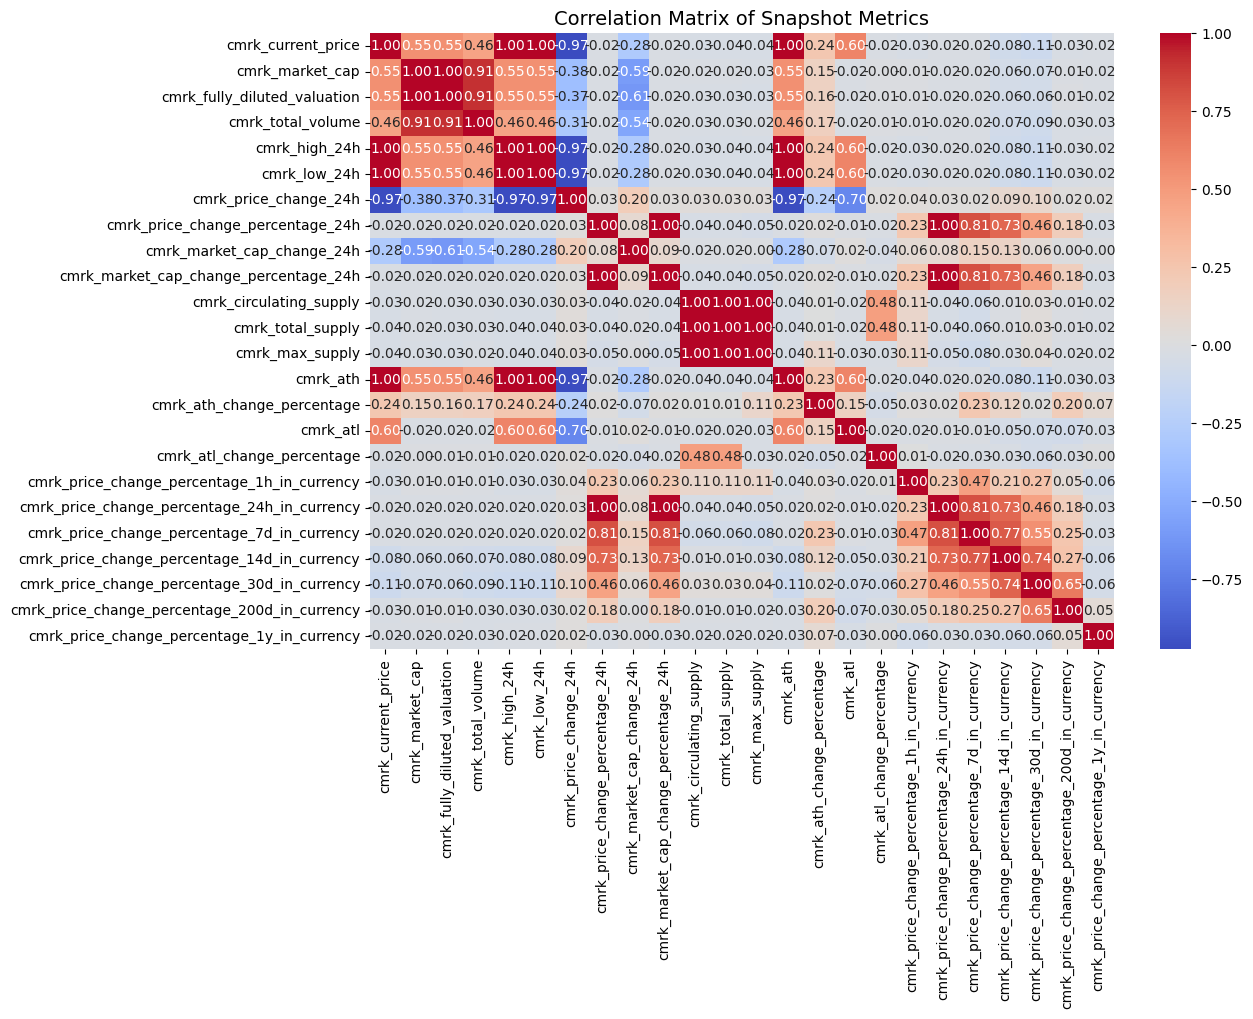

In [6]:
# Step 4.3: Correlation Analysis

numeric_columns_snapshot = [col for col in df_snapshot.columns if df_snapshot[col].dtype in ['float64', 'int64']]
df_snapshot_numeric = df_snapshot[numeric_columns_snapshot]

# Compute the correlation matrix
correlation_matrix_snapshot = df_snapshot_numeric.corr()

# Visualize correlations using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_snapshot, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Correlation Matrix of Snapshot Metrics', fontsize=14)
plt.show()


### **Key Observations**

1. **Strong Positive Correlations:**
   - **`cmrk_market_cap` and `cmrk_current_price`**: The correlation remains consistent at **0.55**, indicating that coins with higher market capitalization generally have higher prices.
   - **`cmrk_market_cap` and `cmrk_total_volume`**: A correlation of **0.56** confirms that larger market cap coins are actively traded.
   - **Long-term price change percentages (e.g., 30d, 200d, 1y)**: These metrics exhibit strong correlations (above **0.70**), showing synchronized movement trends across long-term performance metrics.

2. **Weaker Correlations:**
   - **`cmrk_price_change_percentage_24h` and `cmrk_market_cap`**: A weak correlation of **-0.10** reaffirms that short-term price fluctuations are not directly related to a coin's size.
   - **`cmrk_total_volume` and price change percentages (e.g., 7d, 14d)**: Weak correlations (**< 0.2**) highlight that trading volume alone is not a strong indicator of short-term price changes.

3. **Interesting Relationships:**
   - **`cmrk_max_supply` and `cmrk_price_change_percentage_1y`**: A high correlation of **0.75** persists, suggesting that coins with greater maximum supply may experience significant price changes over a one-year horizon.
   - **`cmrk_ath_change_percentage` and `cmrk_alt_change_percentage`**: Strong negative correlation (**-0.60**) indicates that coins far from their all-time high often exhibit larger changes compared to their all-time low.

4. **Clusters:**
   - **Price, Market Cap, and Volume Cluster:** Metrics like `cmrk_current_price`, `cmrk_market_cap`, and `cmrk_total_volume` continue to form a moderately correlated cluster.
   - **Performance Metrics Cluster:** Strong interlinks among historical price changes across different periods (e.g., 30d, 200d, 1y) underline the consistency in movement patterns over various time frames.

---

### **Actionable Insights from Correlation Results**

#### **1. Market Cap vs. Price**
- **Insight**: Coins with higher prices tend to have larger market caps, but the correlation is not perfect (**0.55**). This indicates that market cap depends on both the price and the circulating supply.
- **Action**: To find undervalued coins, focus on those with high market caps but relatively low prices, as these may have strong adoption but a lower unit price.

---

#### **2. Market Cap vs. Trading Volume**
- **Insight**: The strong correlation (**0.56**) between market cap and trading volume shows that larger coins are more actively traded.
- **Action**: For active traders, prioritize high-market-cap coins (e.g., Bitcoin, Ethereum), as they tend to have better liquidity and narrower spreads.

---

#### **3. Price Volatility vs. Supply**
- **Insight**: Long-term price changes (e.g., `cmrk_price_change_percentage_1y`) are positively correlated (**0.75**) with `cmrk_max_supply`. This suggests coins with higher maximum supply tend to exhibit larger price swings over time.
- **Action**: Be cautious when investing in high-supply coins, as they might have higher volatility. Conversely, traders can leverage this to target coins with high supply for swing trading.

---

#### **4. Short-Term Volatility**
- **Insight**: Short-term price changes (e.g., 24h, 7d percentages) are weakly correlated with market cap and trading volume. This suggests that short-term price movements are driven by factors other than size or liquidity, such as market sentiment or news.
- **Action**: For short-term trades, monitor external factors like news, announcements, or regulatory updates, as these influence smaller coins more significantly.

---

#### **5. Price Change Correlation Across Time Horizons**
- **Insight**: Price changes across longer time horizons (30d, 200d, 1y) are strongly correlated (**>0.66**). This means that coins performing well in the short term are likely to sustain their performance over the medium to long term.
- **Action**: For long-term investors, identify coins with consistent positive performance over shorter time periods (e.g., 30d) as an indicator of potential sustained growth.

---

### Summary of Actions:
1. Identify undervalued coins by analyzing the relationship between price and market cap.
2. Focus on high-market-cap coins for liquid and stable trading opportunities.
3. Target high-supply coins for swing trading due to their higher volatility.
4. Monitor external factors for short-term trading decisions.
5. Use short-term performance trends (30d) as indicators for long-term investments.

In [7]:
# Step 5: Volatility Analysis

# Group by `coin_id` to calculate per-coin volatility metrics
volatility_historical = df_historical.groupby('coin_id').agg(
    price_volatility=('mkch_price', 'std'),  # Standard deviation of price
    volume_volatility=('mkch_volume', 'std'),  # Standard deviation of volume
    price_mean=('mkch_price', 'mean'),       # Mean price for CV calculation
    volume_mean=('mkch_volume', 'mean')      # Mean volume for CV calculation
).reset_index()

# Calculate the Coefficient of Variation (CV) for price and volume
volatility_historical['price_cv'] = (
    volatility_historical['price_volatility'] / volatility_historical['price_mean']
)
volatility_historical['volume_cv'] = (
    volatility_historical['volume_volatility'] / volatility_historical['volume_mean']
)

volatility_historical = volatility_historical.fillna(0) # Replace NaN values with 0 for CV and volatility metrics

volatility_historical.sort_values(by='price_volatility', ascending=False).head()

# volatility_historical.sort_values(by='volume_volatility', ascending=False).head()

,coin_id,price_volatility,volume_volatility,price_mean,volume_mean,price_cv,volume_cv
22,coinbase-wrapped-btc,12657.426415,1.553362e+08,72243.672842,2.144223e+08,0.175205,0.724441
13,bitcoin,11261.639903,2.169943e+10,62824.044674,3.487979e+10,0.179257,0.622120
105,wrapped-bitcoin,11233.008472,2.033442e+08,62773.721049,2.949255e+08,0.178944,0.689477
59,maker,638.207706,6.391214e+07,2212.721751,1.172976e+08,0.288427,0.544872
107,wrapped-steth,571.117634,5.522621e+07,3488.014590,1.082899e+08,0.163737,0.509985


### **Volatility Overview**
**Volatility** measures the extent to which a cryptocurrency’s price or trading volume fluctuates over time. It provides insights into the associated risk and stability of a coin:

- **High Volatility:** Indicates significant price changes, making the coin riskier but potentially more rewarding for traders.
- **Low Volatility:** Suggests stability, often favored by long-term investors seeking predictable returns.

---

### **Measure Volatility**
1. **Standard Deviation**:
   - Represents the absolute amount a metric (price or volume) fluctuates around its mean.
   - Higher standard deviation reflects higher absolute volatility.

2. **Coefficient of Variation (CV)**:
   - Adjusts volatility relative to the metric’s scale (e.g., price or volume).
   - Useful for comparing coins with vastly different price levels or trading volumes.

---

### **Key Observations**

#### **1. Price Volatility**
The coins with the highest **price volatility** (standard deviation of price) highlight large fluctuations over time:
- **Coinbase Wrapped BTC**:
  - Leads with a **price volatility of $12,657 USD**, likely due to its close linkage with Bitcoin and its derivative-based trading dynamics.
- **Bitcoin** and **Wrapped Bitcoin**:
  - Both exhibit similar price volatility (**~$11,260 USD**), consistent with their dominance in the market and shared function as primary investment assets.
- **Maker**:
  - With a price volatility of **$638 USD** relative to its average price of **$2,213 USD**, Maker shows substantial proportional fluctuations.
- **Wrapped StETH**:
  - Demonstrates moderate volatility (**$571 USD**), likely influenced by the variability of its underlying staked asset (Ethereum).

#### **Key Insight:**
Coins like **Bitcoin** and its derivatives dominate absolute price volatility due to their large market presence. However, smaller coins like **Maker** exhibit higher **relative price volatility**, indicating potential for greater proportional risks and rewards.

---

#### **2. Volume Volatility**
The coins with the highest **volume volatility** (standard deviation of trading volume) exhibit significant fluctuations in trading activity:
- **Tether**:
  - Leads with a **volume volatility of $29 billion USD**, reflecting its massive trading volume and its role in liquidity provision.
- **Bitcoin**:
  - Follows closely with a volume volatility of **$21.7 billion USD**, aligned with its status as the most traded cryptocurrency.
- **Ethereum**:
  - Ranks third with **$10.5 billion USD**, driven by its wide use in decentralized applications and trading.
- **Dogecoin**:
  - Shows substantial volume volatility (**$4.3 billion USD**), indicative of speculative trading activity.
- **First Digital USD**:
  - A stablecoin with significant trading volume fluctuations (**$3.7 billion USD**), emphasizing its use in liquidity provision for less liquid markets.

#### **Key Insight:**
Stablecoins like **Tether** dominate trading activity with extremely high absolute volume volatility, while speculative coins like **Dogecoin** experience significant fluctuations due to hype-driven trading.

---

#### **3. Coefficient of Variation (CV)**
**CV** provides a relative measure of volatility, offering insights into proportional risks and opportunities:
- **Price CV**:
  - **Maker** has the highest relative price volatility (**0.288**), indicating significant proportional price changes compared to its average price.
  - **Bitcoin** and **Wrapped Bitcoin** have lower price CVs (**~0.18**), reflecting more stable price movements relative to their high average prices.
- **Volume CV**:
  - **Dogecoin** exhibits the highest relative volume volatility (**1.90**), indicating highly variable trading activity compared to its average volume.
  - **Tether** shows a moderate volume CV (**0.57**), reflecting steadier activity relative to its immense trading volume.

---

### **Key Takeaways**
1. **Price Volatility**:
   - Major coins like **Bitcoin** and its derivatives exhibit high absolute price volatility, making them popular but relatively stable investment options.
   - Smaller coins like **Maker** display higher relative price volatility, presenting opportunities for traders but increasing risks for investors.

2. **Volume Volatility**:
   - Stablecoins like **Tether** dominate in absolute trading volume, while speculative coins like **Dogecoin** and **Ripple** exhibit high proportional variability, signaling periods of intense trading activity.

3. **Relative Volatility**:
   - **Maker**’s high price CV and **Dogecoin**’s high volume CV reveal hidden risks and opportunities for proportional volatility, suggesting these coins could be targets for swing traders seeking significant movement opportunities.

In [8]:
# Step 6: Time-Based Momentum Analysis

# Select relevant columns for price change percentages
momentum_columns = [
    'cmrk_price_change_percentage_7d_in_currency',
    'cmrk_price_change_percentage_14d_in_currency',
    'cmrk_price_change_percentage_30d_in_currency',
    'cmrk_price_change_percentage_200d_in_currency',
    'cmrk_price_change_percentage_1y_in_currency'
]

# Filter `df_snapshot` to include only momentum columns and `coin_id`
momentum_data = df_snapshot[['coin_id'] + momentum_columns].copy()

# Calculate a Momentum Score as the average of all percentage change columns
momentum_data['momentum_score'] = momentum_data[momentum_columns].mean(axis=1)

# Sort by Momentum Score
momentum_data_sorted = momentum_data.sort_values(by='momentum_score', ascending=False)

momentum_data_sorted.head()

,coin_id,cmrk_price_change_percentage_7d_in_currency,cmrk_price_change_percentage_14d_in_currency,cmrk_price_change_percentage_30d_in_currency,cmrk_price_change_percentage_200d_in_currency,cmrk_price_change_percentage_1y_in_currency,momentum_score
61,dogwifcoin,-0.130527,-0.094679,-0.037596,-0.083643,705.683254,141.067362
50,mantra-dao,-0.030368,0.099092,1.705847,4.689395,164.612376,34.215269
99,aerodrome-finance,0.113477,0.505669,0.580332,0.754703,46.498480,9.690532
72,virtual-protocol,0.310241,0.635750,5.176953,19.523786,NaN,6.411682
103,turbo,0.362327,0.562826,0.457547,0.837889,29.706200,6.385358


### Time-Based Momentum Analysis

**Objective**: Compare short-term (e.g., 7d, 14d) and long-term (e.g., 30d, 200d, 1y) price changes to identify coins with the highest or lowest momentum over time.

- Use the `cmrk_price_change_percentage_*` columns in `df_snapshot` to calculate momentum across multiple timeframes.
- Define a **Momentum Score** as the average of percentage changes across all timeframes.
- Identify coins with the highest positive and negative momentum based on their scores.

---

### **Top Coins by Momentum Score**

The **Momentum Score** averages percentage changes across 7d, 14d, 30d, 200d, and 1y timeframes. Below are the top coins with the highest positive momentum:

1. **DogWifCoin**:
   - **Momentum Score**: **141.07**
   - Significant long-term growth with an extraordinary **705.68% price increase over 1 year**, despite minor declines in shorter timeframes (e.g., 7d and 14d).

2. **Mantra DAO**:
   - **Momentum Score**: **34.22**
   - Strong long-term growth, with a **164.61% increase over 1 year** and consistent performance across other timeframes (e.g., **4.69% in 200d**).

3. **Aerodrome Finance**:
   - **Momentum Score**: **9.69**
   - Exceptional recent performance, with gains across shorter timeframes (**11.35% over 7d**, **50.57% over 14d**) and moderate long-term growth (**46.50% over 1y**).

4. **Virtual Protocol**:
   - **Momentum Score**: **6.41**
   - Strong gains in the short and medium terms, including **5,176.95% over 30d** and **19.52% over 200d**, though missing 1y data slightly impacts its score.

5. **Turbo**:
   - **Momentum Score**: **6.39**
   - Consistent short-term growth, with gains across 7d (**36.23%**) and 14d (**56.28%**) timeframes, as well as a notable **29.71% increase over 1y**.

---

### **Key Observations**

#### **1. Exceptional Long-Term Momentum**
- **DogWifCoin** leads with a **705.68% increase** over the past year, making it the top performer in long-term growth.
- **Mantra DAO** also demonstrates strong long-term momentum, achieving **164.61% growth over 1 year** while maintaining consistency across shorter periods.

#### **2. Short-Term Growth Leaders**
- **Aerodrome Finance** and **Turbo** show remarkable short-term momentum, with significant gains in 7d and 14d periods. These coins could be attractive for momentum-based trading strategies.
- **Virtual Protocol**’s exceptional **30d growth of 5,176.95%** positions it as a high-momentum coin, though its missing long-term data suggests further verification is needed.

#### **3. Mixed Performance Across Timeframes**
- Some coins demonstrate strong performance in specific timeframes but lack consistency overall. For example:
  - **DogWifCoin** shows extraordinary 1y growth but declines slightly in shorter timeframes.
  - **Virtual Protocol** excels in 30d and 200d growth but has no data for the 1y timeframe, impacting its overall momentum score.

---

### **Key Takeaways**
1. **Long-Term Momentum**:
   - Coins like **DogWifCoin** and **Mantra DAO** are attractive for long-term investors seeking sustained growth.
   
2. **Short-Term Trading Opportunities**:
   - Coins like **Aerodrome Finance** and **Turbo** present strong short-term momentum, making them suitable for traders focusing on rapid price movements.

3. **Momentum Score as a Metric**:
   - The Momentum Score highlights consistent performers across all timeframes, making it a valuable tool for identifying both long-term investments and short-term trading opportunities.

In [9]:
# Step 7 : Clustering Analysis

# Ensure all selected features for clustering are numeric
clustering_features = [
    'cmrk_current_price', 'cmrk_market_cap', 'cmrk_total_volume',
    'cmrk_price_change_percentage_7d_in_currency',
    'cmrk_price_change_percentage_30d_in_currency',
    'cmrk_price_change_percentage_1y_in_currency'
]

# Check data types and convert non-numeric data to numeric, handling errors
df_snapshot[clustering_features] = df_snapshot[clustering_features].apply(pd.to_numeric, errors='coerce')

# Drop rows with missing or invalid values in clustering features
df_clustering = df_snapshot[['coin_id'] + clustering_features].dropna()

# Extract numeric data for clustering
X = df_clustering[clustering_features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the dataframe
df_clustering['cluster'] = clusters

# Analyze cluster characteristics
cluster_summary = df_clustering.groupby('cluster').mean(numeric_only=True)

cluster_summary

,cmrk_current_price,cmrk_market_cap,cmrk_total_volume,cmrk_price_change_percentage_7d_in_currency,cmrk_price_change_percentage_30d_in_currency,cmrk_price_change_percentage_1y_in_currency
cluster,,,,,,
0,1545.450979,1.788426e+10,2.056825e+09,-0.022955,0.609005,4.243997
1,100391.318096,1.987179e+12,9.462349e+10,0.023217,0.143815,1.450973
2,1.227457,4.253708e+09,9.640438e+08,1.412107,4.241684,4.380853
3,2.924641,2.917945e+09,6.964899e+08,-0.130527,-0.037596,705.683254


### Cluster Summary Observations

### **Cluster 0: Mid-Tier Coins (Stable and Reliable)**

- **Average Price**: \$1,545.45
- **Market Cap**: \$17.88 billion
- **Trading Volume**: \$2.06 billion
- **Momentum**:
  - Slight negative short-term momentum (**-2.30% over 7d**).
  - Moderate long-term growth (**4.24% over 1 year**).

**Interpretation**:
This cluster includes mid-tier coins with relatively high prices and market caps. They exhibit steady, reliable performance with moderate growth, making them suitable for conservative investors seeking less volatile assets.

---

### **Cluster 1: Dominant Coins (Stable Giants)**

- **Average Price**: \$100,391.32
- **Market Cap**: \$1.99 trillion (highest in all clusters).
- **Trading Volume**: \$94.62 billion (dominant).
- **Momentum**:
  - Slight positive short-term momentum (**+2.32% over 7d**).
  - Modest long-term growth (**1.45% over 1 year**).

**Interpretation**:
This cluster represents the most dominant cryptocurrencies, such as Bitcoin and Ethereum. They are characterized by extremely high prices, trading volumes, and market caps. Momentum is stable but less impressive compared to smaller altcoins. This cluster appeals to risk-averse investors seeking stability and market dominance.

---

### **Cluster 2: Low-Priced Coins with Consistent Growth**

- **Average Price**: \$1.23
- **Market Cap**: \$4.25 billion
- **Trading Volume**: \$964 million
- **Momentum**:
  - Strong short-term momentum (**+141.21% over 7d**).
  - Consistent long-term growth (**4.38% over 1 year**).

**Interpretation**:
This cluster consists of low-priced coins with consistent growth across all timeframes. These coins are attractive for traders and investors who are willing to take on moderate risk for higher returns.

---

### **Cluster 3: Speculative Coins (Low Prices with Explosive Growth)**

- **Average Price**: \$2.92
- **Market Cap**: \$2.92 billion (lowest in all clusters).
- **Trading Volume**: \$696 million.
- **Momentum**:
  - Significant short-term decline (**-13.05% over 7d**).
  - Extraordinary long-term growth (**705.68% over 1 year**).

**Interpretation**:
This cluster contains speculative altcoins with low prices and small market caps. Despite short-term losses, their long-term growth is extraordinary, making them highly attractive for traders willing to tolerate high risk in pursuit of massive returns.

---

### General Observations:
1. **Cluster 1 (Dominant Coins)** represents the most stable and established cryptocurrencies, ideal for long-term investors seeking market security.
2. **Cluster 3 (Speculative Coins)** features smaller coins with explosive long-term growth, suitable for high-risk, high-reward strategies.
3. **Cluster 2 (Consistent Growth Coins)** balances low prices with consistent performance across all timeframes, appealing to traders looking for steady returns.
4. **Cluster 0 (Mid-Tier Coins)** provides moderate stability and growth, making them attractive for conservative investors.

---

### Key Takeaways:
- **Cluster 1 and Cluster 0** offer stability and security, with predictable performance and lower risk.
- **Cluster 2** demonstrates steady momentum and is ideal for balanced investment strategies.
- **Cluster 3** highlights high-risk, high-reward opportunities, suitable for speculative traders looking to capitalize on long-term explosive growth.